# **Predicting the Qualitity of Red Wine**

In [118]:
#import the relevant packages
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

Import the csv file that houses the data.

In [119]:
df = pd.read_csv("red_wine_quality.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,origin
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Imported
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,Local
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,Imported
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,Local
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Local


In [120]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
 12  origin                1599 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 162.5+ KB
None
       fixed acidity  volatile acidity  citric acid  resid

All our data except for origin is numeric. We need to change origin to a category so we can use it in our model.

In [121]:
df["origin"] = df["origin"].astype("category")
df.info()
df["origin"] = df["origin"].cat.codes
print(df["origin"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed acidity         1599 non-null   float64 
 1   volatile acidity      1599 non-null   float64 
 2   citric acid           1599 non-null   float64 
 3   residual sugar        1599 non-null   float64 
 4   chlorides             1599 non-null   float64 
 5   free sulfur dioxide   1599 non-null   float64 
 6   total sulfur dioxide  1599 non-null   float64 
 7   density               1599 non-null   float64 
 8   pH                    1599 non-null   float64 
 9   sulphates             1599 non-null   float64 
 10  alcohol               1599 non-null   float64 
 11  quality               1599 non-null   int64   
 12  origin                1599 non-null   category
dtypes: category(1), float64(11), int64(1)
memory usage: 151.7 KB
0       0
1       1
2       0
3       1
4      

Quality is the feature we are interested in predicting, so lets define our data sets.

In [122]:
X = df.drop(["quality"], axis=1)
y = df[["quality"]]

We need to ensure that when we split our data into a test and train set that we have sample representative of the data set. Let's consider the distribution of wine quality.

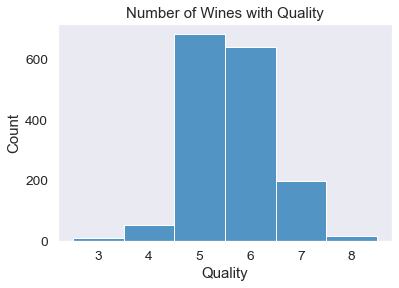

In [123]:
sns.set_style("dark")
sns.set_context("notebook", font_scale=1.25)
plot = sns.histplot(data=y, x="quality", discrete=True)

plt.xlabel("Quality")
plt.ylabel("Count")
plt.title("Number of Wines with Quality")

plt.show()

We will stratify on quality (y values) in order to ensure are model encounters all potential values for wine quality.

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

print(pd.unique(y_train["quality"]))
print(pd.unique(y_test["quality"]))

[6 5 7 3 4 8]
[6 5 4 8 7 3]


Let's test a Random Forest model on our data to get a sense of what values are important to the model

In [125]:
clf = RandomForestClassifier(n_estimators=100, criterion="entropy")
clf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(criterion='entropy')

No handles with labels found to put in legend.


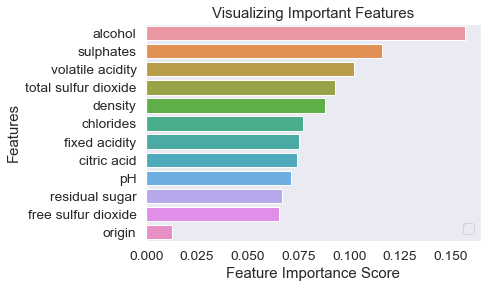

In [126]:
features = X_train.columns
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

It turns out that origin doesn't have much impact to qaulity. This is probably good as qaulity is usually determined by people so there doesn't seem to be a bias due to where the wine came from (at least in the sense of whether the wine is of the home country or not).

We should drop this feature, as it could add noise to the model decreasing the accuracy of our model.

In [127]:
X = X.drop(["origin"], axis=1)

We are unsure which parameters to use for this Random Forest classifier. To combat indecisivness, we'll use a parameter grid with some various choices for some of the parameters in the Random Forest classifier. After that, we will use a GridSearch with a 5-cross validation in order to determine which parameters perform the best.

In [128]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_features": ["auto", "sqrt", "log2"],
    "n_estimators": [10, 100, 200, 400, 800],
    "min_samples_split": [2, 5, 10, 20]
}

rf_clf = RandomForestClassifier(random_state=42)
gs_cv = GridSearchCV(rf_clf, param_grid, cv=5).fit(X_train, y_train.values.ravel())

print(gs_cv.best_estimator_)
print(gs_cv.best_score_)

RandomForestClassifier(criterion='entropy', min_samples_split=5,
                       n_estimators=800, random_state=42)
0.6841145833333333


We can take the model with the best parameters (from the ones we selected in param_grid), by calling best_estimator_ on our GridSearchCV. From there, we can predict outcomes on our test data. We then plot the histogram of outcomes to get a visual on how close are model is.

0.6875


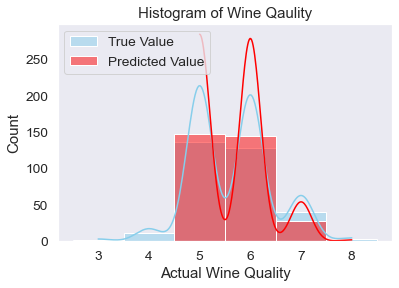

In [129]:
y_pred = gs_cv.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

sns.histplot(y_test.values.ravel(), color="skyblue", label="True Value", kde=True, discrete=True)
sns.histplot(y_pred, color="red", label="Predicted Value", kde=True, discrete=True)

plt.xlabel('Actual Wine Quality')
plt.ylabel('Count')
plt.title("Histogram of Wine Qaulity")
plt.legend() 
plt.show()

Not bad. It seems as though the Random Forest model has issues on predicting the quality correctly for values of 3, 4, and 8. To solve this, we could try and find more data for wine with these quality values. We could also pick another type of classifier and see if it yeilds better results. It could also be the case that none of the features in this data set are good predictors of high quality wines (>8) or low quality wines (<4).